In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [2]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget --no-check-certificate -nc 'https://docs.google.com/uc?export=download&id=1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_' -O spam.csv

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

df.head()


--2022-04-23 17:04:28--  https://docs.google.com/uc?export=download&id=1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_
Resolving docs.google.com (docs.google.com)... 74.125.142.138, 74.125.142.139, 74.125.142.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tapaeo3rg8pilp5nv4hped1344hvg90o/1650733425000/08702983968081230261/*/1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_?e=download [following]
--2022-04-23 17:04:29--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tapaeo3rg8pilp5nv4hped1344hvg90o/1650733425000/08702983968081230261/*/1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.goog

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# rename columns to something better
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [7]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [8]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [9]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7206 unique tokens.


In [10]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

Shape of data train tensor: (3733, 189)


In [12]:
# get sequence length
T = data_train.shape[1]
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [13]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

spam_freq = df[df['labels'] == 'spam'].size / df.size
print(spam_freq)

0.13406317300789664


In [14]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=5,
  validation_data=(data_test, Ytest),
  class_weight={0: 1, 1: 1 / spam_freq}
)

Training model...
Epoch 1/5
117/117 [==============================] - 11s 26ms/step - loss: 1.0487 - accuracy: 0.8393 - val_loss: 0.4608 - val_accuracy: 0.9744
Epoch 2/5
117/117 [==============================] - 2s 21ms/step - loss: 0.4626 - accuracy: 0.9818 - val_loss: 0.1807 - val_accuracy: 0.9831
Epoch 3/5
117/117 [==============================] - 2s 15ms/step - loss: 0.2098 - accuracy: 0.9885 - val_loss: 0.1296 - val_accuracy: 0.9712
Epoch 4/5
117/117 [==============================] - 1s 11ms/step - loss: 0.1255 - accuracy: 0.9917 - val_loss: 0.0823 - val_accuracy: 0.9842
Epoch 5/5
117/117 [==============================] - 1s 11ms/step - loss: 0.0888 - accuracy: 0.9933 - val_loss: 0.0788 - val_accuracy: 0.9842


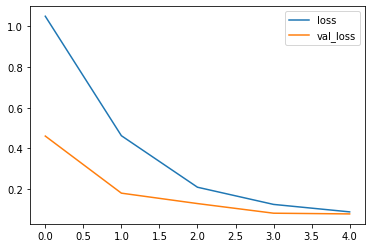

In [15]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

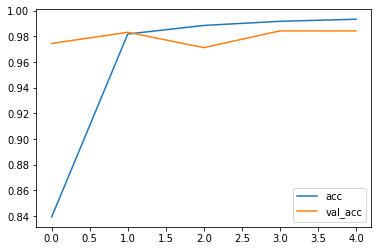

In [16]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [17]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  

p_test = np.round(model.predict(data_test))
cm = confusion_matrix(Ytest, p_test)
plot_confusion_matrix(cm, [0, 1])

p_train = np.round(model.predict(data_train))
cm = confusion_matrix(Ytrain, p_train)
plot_confusion_matrix(cm, [0, 1])


Confusion matrix, without normalization
[[1558   10]
 [  19  252]]
Confusion matrix, without normalization
[[3247   10]
 [   1  475]]


In [18]:
### Make predictions on a new test sentence ###
# test_sent = df[df.labels == 'spam'].sample()['data'].values
test_sent = ['Not heard from U4 a while. Call 4 rude chat private line']
print("Sentence:", test_sent)
test_seq = tokenizer.texts_to_sequences(test_sent)
test_seq

test_padded = pad_sequences(test_seq, maxlen=T)
test_padded


Sentence: ['Not heard from U4 a while. Call 4 rude chat private line']


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [19]:
# correctly identified as spam
model.predict(test_padded)

array([[0.9753591]], dtype=float32)